## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:01<00:00, 60.3MB/s]


In [2]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=2a2c8952-f43e-4a33-9751-6945cbff9511
To: /content/coco_captions.npy
100% 415M/415M [00:10<00:00, 40.3MB/s]


### 1.1 Use MyDrive Data

In [ ]:
!gdown 18tJSfIsfouYw5oVgslXmkDlKlbPKnNat

/bin/bash: line 1: gdown: command not found


In [ ]:
!gdown 19R7kjrkpDrLOfMEOu5UAmpnqSRLwIgka

/bin/bash: line 1: gdown: command not found


In [3]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.jpg  
 extracting: val2014/COCO_val2014_000000347422.j

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [6]:
def visualize_image(image):
    # convert the image tensor to numpy array and transpose it to (height, width, channels)
    image = image.numpy().transpose((1, 2, 0))

    # unnormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Clip the values to be in the range [0, 1]

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

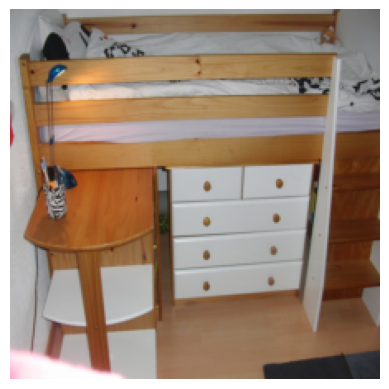

In [7]:
# Display the image using Matplotlib
visualize_image(img)

In [8]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [9]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [10]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [11]:
caption_embeddings[0][0][:10]

array([-2.9846387e-02, -2.7121352e-02,  5.2404514e-05, -2.2670999e-02,
       -3.1265341e-02,  6.3304655e-02,  4.8953880e-02, -1.3584862e-02,
        1.7688539e-02, -2.3541721e-02], dtype=float32)

In [12]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [13]:
def cosine_similarity(vec1, vec2):
    dot_prod = np.dot(vec1, vec2)
    m1 = np.linalg.norm(vec1) # l2 norm of vector 1
    m2 = np.linalg.norm(vec2)
    return dot_prod/ (m1 * m2)

def closest_index(query, nearest_neighbours):
    max_sim = -1
    I, J = -1, -1
    for nei_i in nearest_neighbours:
        for j in range(caption_embeddings.shape[1]):
            sim = cosine_similarity(caption_embeddings[nei_i][j], query)
            if sim > max_sim:
                max_sim = sim
                I = nei_i
                J = j
    return I, J

### 1.2 kNN Faiss Implementation

In [14]:
def knn_captioning(k, method, start=0, end=len(image_embeddings)):
    # captions_flat = captions_np.flatten().tolist()
    caption_pred = []
    captions_real = []
    images = []

    if method == 1:
        index = faiss.IndexFlatL2(image_embeddings.shape[1])
    elif method == 2:
        index = faiss.IndexHNSWFlat(image_embeddings.shape[1], 32)  # use HNSW index with 32 neighbors
    elif method == 3:
        index = faiss.IndexFlatIP(image_embeddings.shape[1])  # use Inner Product similarity
    else:
        quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])  # Quantizer for the IVF index
        index = faiss.IndexIVFFlat(quantizer, image_embeddings.shape[1], 100)  # 100 clusters
        index.train(image_embeddings)  # Train the IVF index
    index.add(image_embeddings)


    for i in range(start, end):
        # search k+1 similar images
        # since the image itself will be closest to it, we will remove the 1st one
        _, nn = index.search(image_embeddings[i: i+1], k+1) # slicing ensures a 2d array is passed to search function
        nn = nn.flatten() # nearest neighbours
        nn = nn[1: ]

        query_vector = np.zeros_like(image_embeddings[0])
        for nei_index in nn:
            sim = cosine_similarity(image_embeddings[nei_index], image_embeddings[i])
            query_vector += sim * np.sum(caption_embeddings[i], axis = 0)
        query_vector /= (5*k) # shape (512,)

        # find closest caption to the query vector
        i_, j_ = closest_index(query_vector, nn)
        caption_pred.append(captions[i_][j_]) # closest(one) caption
        captions_real.append(captions[i]) # list of 5 captions
        # visualize_image(coco_dset[i][0]) # pass the image object from coco dataset

    return caption_pred, captions_real

In [15]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions (list of 5)
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split() # input: sentence

    accuracy = 0
    for i, pred in enumerate(predict):
        refs = real[i] # 5 references to predicted caption
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pred))
        accuracy += score
        # print(score)
    return accuracy/ len(predict)

### 1.3 Different Index Methods With Same k
* Method 1: IndexFlatL2
* Method 2: IndexHNSWFlat
* Method 3: IndexFlatIP
* Method 4: IndexIVFFlat

In [16]:
import time

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

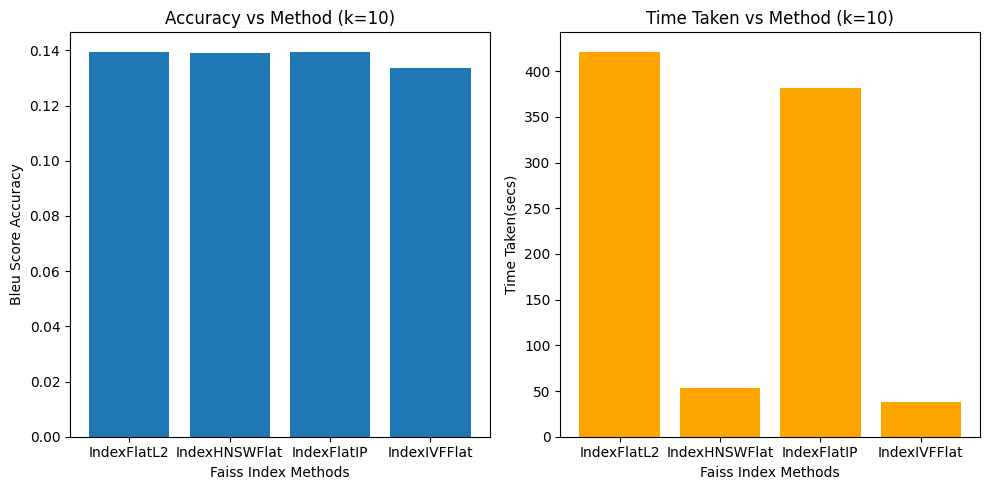

In [17]:
method_dict = {1: 'IndexFlatL2', 2: 'IndexHNSWFlat', 3: 'IndexFlatIP', 4: 'IndexIVFFlat'}
k = 10
accuracies = []
times = []

for m in method_dict.keys():
    # add some way to record time taken
    start_time = time.time()
    caption_predicted, captions_actual = knn_captioning(k, m)
    end_time = time.time()
    acc = accuracy(caption_predicted, captions_actual)
    accuracies.append(acc)
    times.append(end_time - start_time)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(method_dict.values(), accuracies)
plt.xlabel('Faiss Index Methods')
plt.ylabel('Bleu Score Accuracy')
plt.title(f'Accuracy vs Method (k={k})')

# Plot time taken vs method
plt.subplot(1, 2, 2)
plt.bar(method_dict.values(), times, color='orange')
plt.xlabel('Faiss Index Methods')
plt.ylabel('Time Taken(secs)')
plt.title(f'Time Taken vs Method (k={k})')

plt.tight_layout()
plt.show()

#### 1.3.1 Observations:
* All the methods show similar accuracy scores for small k (here 10).
* Methods IndexHNSWFlat and IndexIVFFlat have the lower compute times than the other two for small k. Among them, IndexIVFFlat is the fastest. For this reason, we use this method in our next task and observe accuracy scores for different k values.

### 1.4 IndexIVFFlat Method with Different k

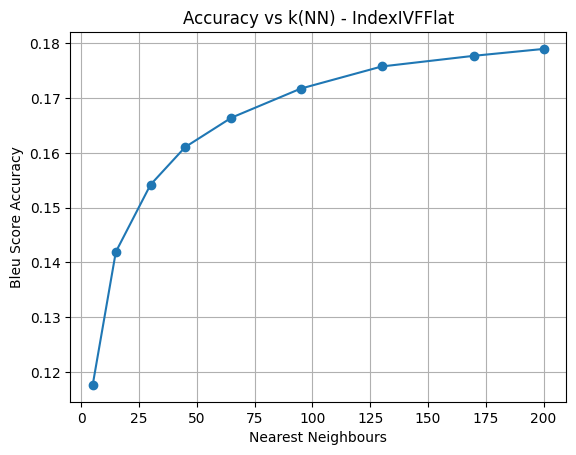

In [18]:
# k_values = list(range(5, 35, 3))
k_values = [5, 15, 30, 45, 65, 95, 130, 170, 200]
accuracies = []
for k in k_values:
    caption_predicted, captions_actual = knn_captioning(k, 4)
    acc = accuracy(caption_predicted, captions_actual)
    accuracies.append(acc)

plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Nearest Neighbours')
plt.ylabel('Bleu Score Accuracy')
plt.title('Accuracy vs k(NN) - IndexIVFFlat')
plt.grid(True)
plt.show()

In [19]:
for i in range(1):
    print(caption_predicted[i])
    print(captions_actual[i])

a little dog sleeping on somebodys shoes 
['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']


### 1.5 Visualize 5 Images and Show Captions

We will use IVFFlatIndex Method on the first five images in the dataset and visualize them.

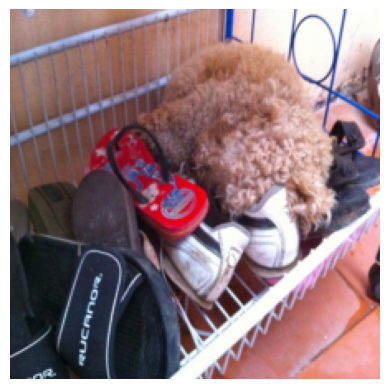

Predicted Caption: A dog sleeping on a bed that is on the ground.
Actual Captions:
1. This wire metal rack holds several pairs of shoes and sandals
2. A dog sleeping on a show rack in the shoes.
3. Various slides and other footwear rest in a metal basket outdoors.
4. A small dog is curled up on top of the shoes
5. a shoe rack with some shoes and a dog sleeping on them


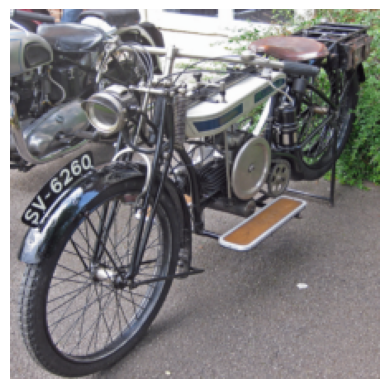

Predicted Caption: a motorcycle that is parked in side a buliding
Actual Captions:
1. A motorcycle parked in a parking space next to another motorcycle.
2. An old motorcycle parked beside other motorcycles with a brown leather seat.
3. Motorcycle parked in the parking lot of asphalt.
4. A close up view of a motorized bicycle, sitting in a rack. 
5. The back tire of an old style motorcycle is resting in a metal stand. 


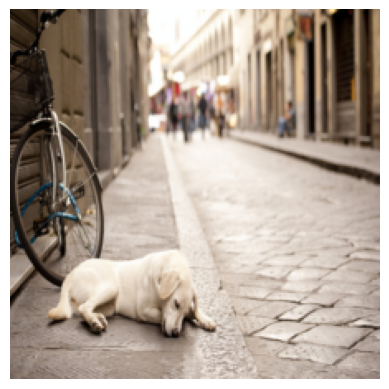

Predicted Caption: a dog sitting on a side walk with a bike near by
Actual Captions:
1. A picture of a dog laying on the ground.
2. Dog snoozing by a bike on the edge of a cobblestone street
3. The white dog lays next to the bicycle on the sidewalk.
4. a white dog is sleeping on a street and a bicycle
5. A puppy rests on the street next to a bicycle.


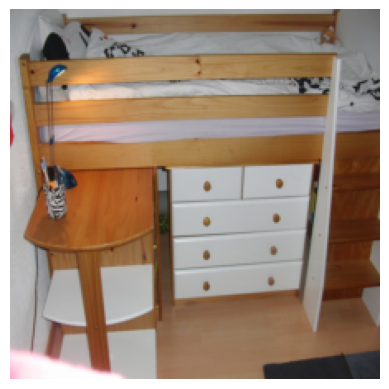

Predicted Caption: A bedroom with a made bed, a dresser, an office chair and a desk.
Actual Captions:
1. A loft bed with a dresser underneath it.
2. A bed and desk in a small room.
3. Wooden bed on top of a white dresser.
4. A bed sits on top of a dresser and a desk.
5. Bunk bed with a narrow shelf sitting underneath it. 


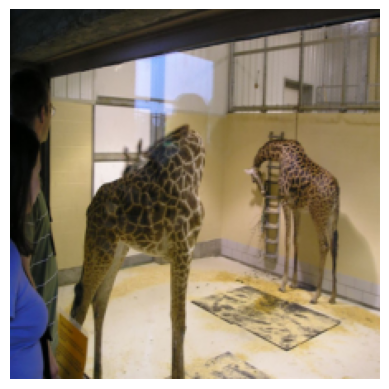

Predicted Caption: A couple of giraffe standing in a building.
Actual Captions:
1. Two giraffes in a room with people looking at them.
2. Two giraffe standing next to each other in a room.
3. The giraffe is being kept by itself indoors. 
4. A man and woman staring at two giraffes through a window.
5. a giraffe in a enclosed area is watched by some people


In [20]:
k = 15
# accuracies = []
n_img = 5
for i in range(n_img):
    caption_predicted, captions_actual = knn_captioning(k, 4, start=i, end=i+1)
    visualize_image(coco_dset[i][0])
    print('Predicted Caption:', caption_predicted[0])
    print('Actual Captions:')
    for j in range(caption_embeddings.shape[1]):
        print(f'{j+1}.', captions_actual[0][j])
